# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set the path to the Datasets folder (assuming your script is in Explore_Data folder)
data_folder = '../Data/'  # This goes up one directory, then into the Data folder

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Load all datasets from the Data folder
customers = pd.read_csv(os.path.join(data_folder, 'olist_customers_dataset.csv'))
orders = pd.read_csv(os.path.join(data_folder, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(data_folder, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(data_folder, 'olist_products_dataset.csv'))
sellers = pd.read_csv(os.path.join(data_folder, 'olist_sellers_dataset.csv'))
order_reviews = pd.read_csv(os.path.join(data_folder, 'olist_order_reviews_dataset.csv'))
order_payments = pd.read_csv(os.path.join(data_folder, 'olist_order_payments_dataset.csv'))
product_category = pd.read_csv(os.path.join(data_folder, 'product_category_name_translation.csv'))
geolocation = pd.read_csv(os.path.join(data_folder, 'olist_geolocation_dataset.csv'))



## Data Cleaning

In [3]:
# Remove duplicate rows (generally safe)
customers = customers.drop_duplicates()
orders = orders.drop_duplicates()
order_items = order_items.drop_duplicates()
products = products.drop_duplicates()
sellers = sellers.drop_duplicates()
order_reviews = order_reviews.drop_duplicates()
order_payments = order_payments.drop_duplicates()
product_category = product_category.drop_duplicates()
geolocation = geolocation.drop_duplicates()

# Handle missing values appropriately for each dataset
# For orders dataset: Keep missing delivery dates as they may be pending orders
orders['order_delivered_customer_date'] = orders['order_delivered_customer_date']
orders['order_delivered_carrier_date'] = orders['order_delivered_carrier_date']
orders['order_approved_at'] = orders['order_approved_at']

# For products: Fill missing category names with 'unknown'
products['product_category_name'] = products['product_category_name'].fillna('unknown')

# For reviews: Fill missing comment fields with empty strings
if 'review_comment_title' in order_reviews.columns:
    order_reviews['review_comment_title'] = order_reviews['review_comment_title'].fillna('')
if 'review_comment_message' in order_reviews.columns:
    order_reviews['review_comment_message'] = order_reviews['review_comment_message'].fillna('')

# Convert date columns in orders dataframe to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

# Convert date columns in order_reviews dataframe to datetime
review_date_columns = ['review_creation_date', 'review_answer_timestamp']
for col in review_date_columns:
    if col in order_reviews.columns:
        order_reviews[col] = pd.to_datetime(order_reviews[col])



# Category Revenue Analysis by Year (2016-2018)

In [4]:

# Combine order_items with products to get the product category
category_sales = order_items.merge(products, on='product_id')

# Join with product category translation to get English category names
category_sales = category_sales.merge(product_category, 
                                     left_on='product_category_name', 
                                     right_on='product_category_name',
                                     how='left')

# Join with orders to get the purchase timestamp
category_sales = category_sales.merge(orders[['order_id', 'order_purchase_timestamp']], 
                                     on='order_id')

#Extract year from timestamp for yearly analysis
category_sales['order_year'] = category_sales['order_purchase_timestamp'].dt.year

# Calculate total revenue by category and year
category_yearly_revenue = category_sales.groupby(['product_category_name_english', 'order_year'])['price'].sum().reset_index()

# Create a pivot table for better visualization of yearly data
revenue_pivot = category_yearly_revenue.pivot(index='product_category_name_english', 
                                             columns='order_year', 
                                             values='price')

# Fill missing values with 0 (categories that had no sales in certain years)
revenue_pivot = revenue_pivot.fillna(0)

#  Add a total column to calculate overall revenue across all years
revenue_pivot['Total'] = revenue_pivot.sum(axis=1)

#  Sort by total revenue to get the most profitable categories
sorted_revenue = revenue_pivot.sort_values('Total', ascending=False)

# Format numbers with commas as thousand separators
pd.options.display.float_format = '{:,.2f}'.format

# Format numbers for better readability (round to 2 decimal places)
formatted_revenue = sorted_revenue.round(2)

# Display the top 20 most profitable categories
print("Top 20 Most Profitable Product Categories by Year (in BRL):")
top_categories = formatted_revenue.head(20)
display(top_categories)



Top 20 Most Profitable Product Categories by Year (in BRL):


order_year,2016,2017,2018,Total
product_category_name_english,,,,
health_beauty,"4,687.48","481,755.71","772,238.15","1,258,681.34"
watches_gifts,"3,360.24","492,794.50","708,850.94","1,205,005.68"
bed_bath_table,478.99,"498,440.43","538,069.26","1,036,988.68"
sports_leisure,"3,333.64","452,148.84","532,566.49","988,048.97"
computers_accessories,"1,399.32","405,078.69","505,476.31","911,954.32"
furniture_decor,"5,880.78","337,213.12","386,668.59","729,762.49"
cool_stuff,"1,111.00","393,620.65","240,559.20","635,290.85"
housewares,"1,287.07","231,073.49","399,888.10","632,248.66"
auto,"1,833.25","243,255.71","347,631.15","592,720.11"


### Plot Results

<Figure size 1200x800 with 0 Axes>

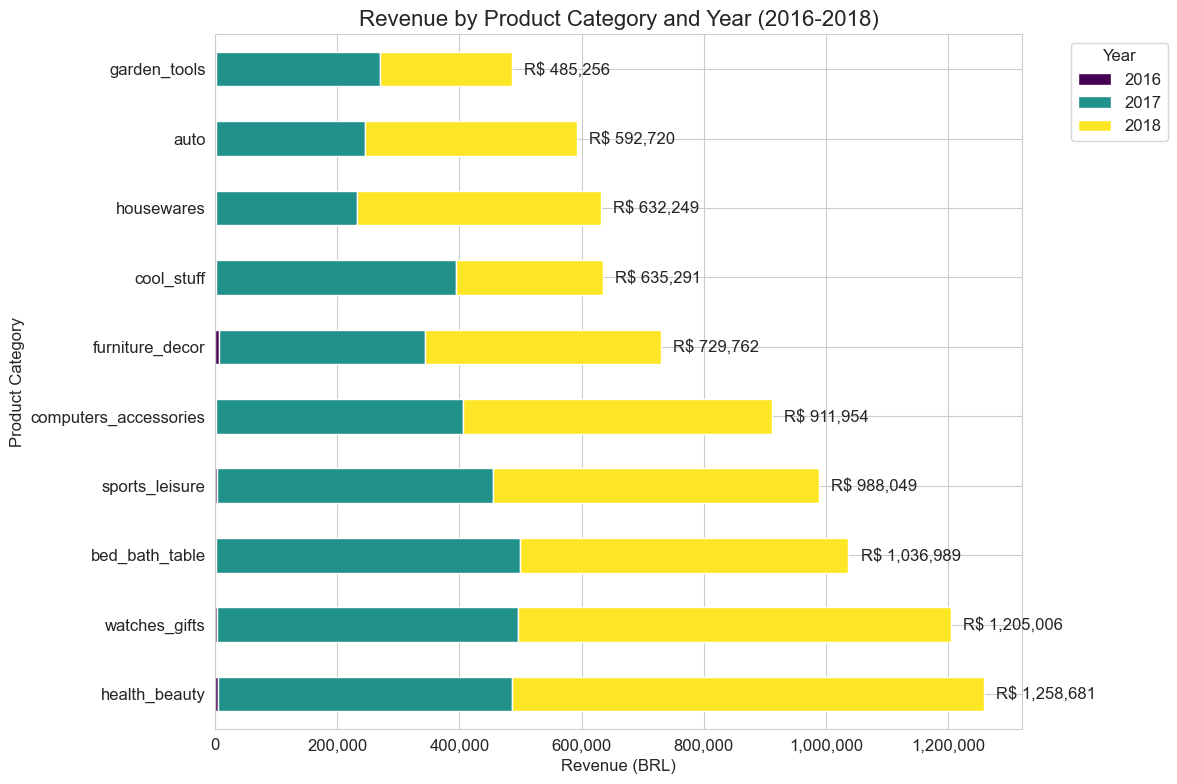

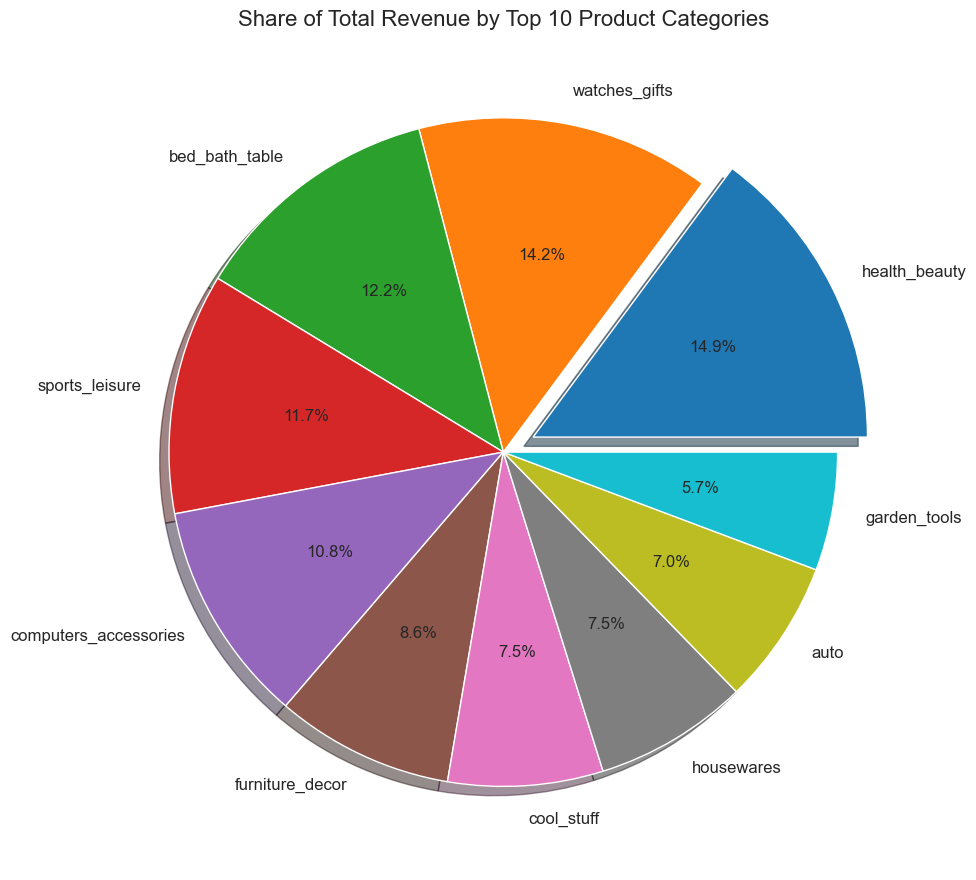

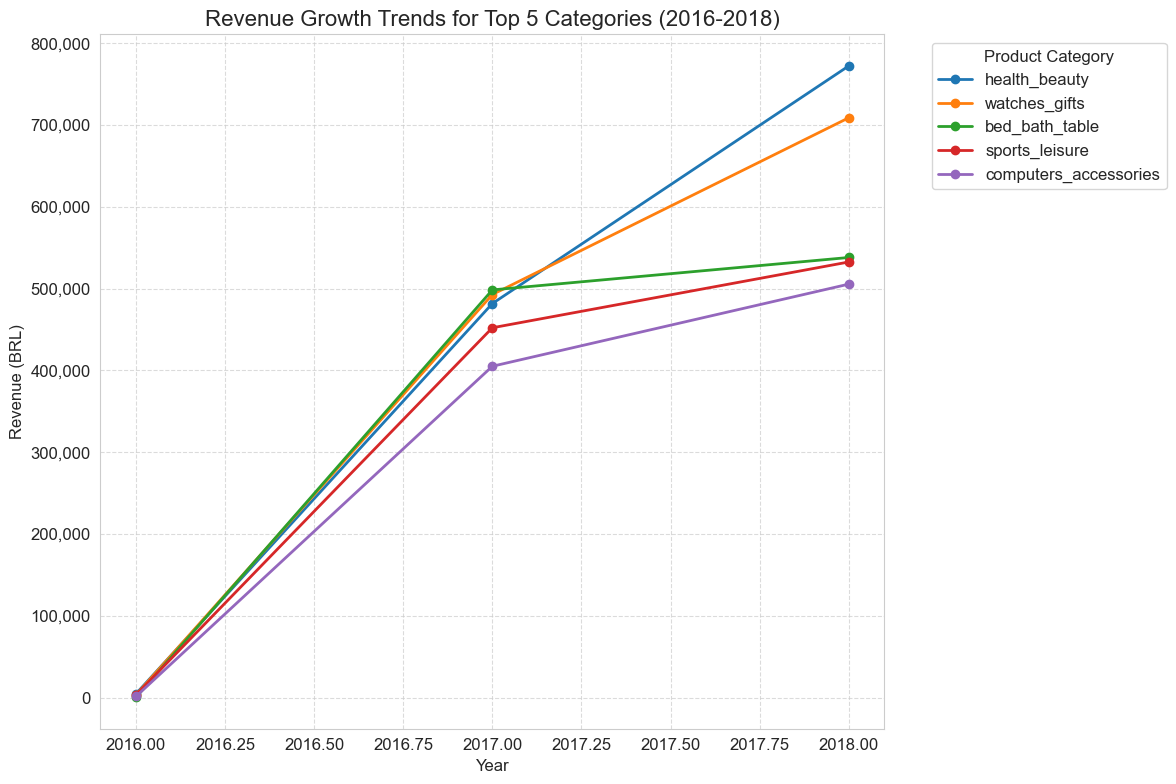

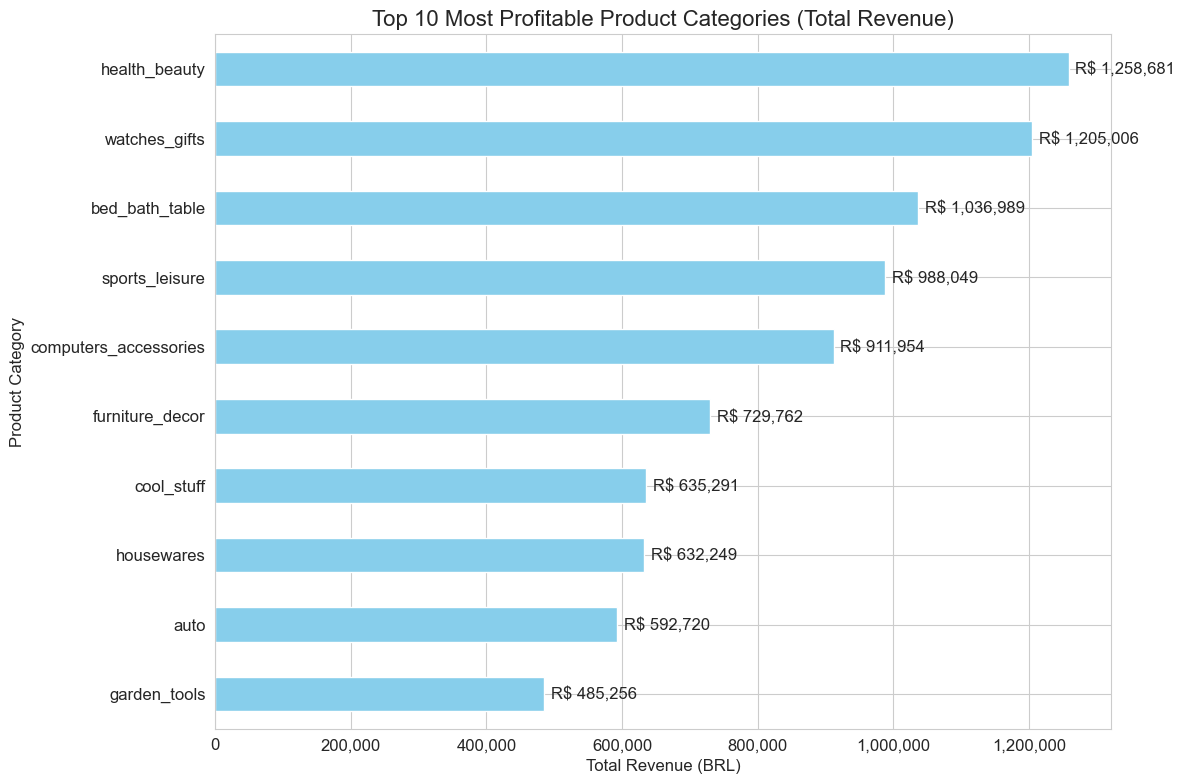

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set global plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_category_revenue_by_year():
    """
    Creates a horizontal stacked bar chart showing revenue contribution 
    by year for each product category.
    """
    plt.figure(figsize=(12, 8))
    
    # Create stacked bar chart for top 10 categories
    ax = formatted_revenue.head(10).drop('Total', axis=1).plot(
        kind='barh', 
        stacked=True, 
        figsize=(12, 8), 
        colormap='viridis'
    )
    
    # Add title and labels
    plt.title('Revenue by Product Category and Year (2016-2018)', fontsize=16)
    plt.xlabel('Revenue (BRL)', fontsize=12)
    plt.ylabel('Product Category', fontsize=12)
    
    # Add a legend with a title
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add total values as text at the end of each bar
    for i, category in enumerate(formatted_revenue.head(10).index):
        total = formatted_revenue.loc[category, 'Total']
        plt.text(total + 20000, i, f'R$ {total:,.0f}', va='center')
    
    # Format x-axis with comma separator for thousands
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.savefig('category_revenue_by_year.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_category_revenue_pie_chart():
    """
    Creates a pie chart showing the proportion of total revenue 
    for the top 10 product categories.
    """
    plt.figure(figsize=(10, 10))
    
    # Explode the first slice (highest revenue category)
    explode = [0.1] + [0] * 9
    
    # Plot pie chart
    formatted_revenue.head(10)['Total'].plot(
        kind='pie', 
        autopct='%1.1f%%', 
        shadow=True, 
        explode=explode,
        labels=formatted_revenue.head(10).index,
        cmap='tab10'
    )
    
    # Add title
    plt.title('Share of Total Revenue by Top 10 Product Categories', fontsize=16)
    plt.ylabel('')  # Hide the y-label
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('category_revenue_pie_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_category_growth_trends():
    """
    Creates a line chart showing the revenue growth trajectory 
    of the top 5 categories over time.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot only the top 5 categories
    for category in formatted_revenue.head(5).index:
        plt.plot(
            formatted_revenue.loc[category].drop('Total').index,
            formatted_revenue.loc[category].drop('Total').values,
            marker='o',
            linewidth=2,
            label=category
        )
    
    # Add title and labels
    plt.title('Revenue Growth Trends for Top 5 Categories (2016-2018)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Revenue (BRL)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format y-axis with comma separator for thousands
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Add legend
    plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('category_growth_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_top_categories_by_total():
    """
    Creates a simple horizontal bar chart of the top 10 categories 
    by total revenue across all years.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot horizontal bar chart
    ax = formatted_revenue.head(10)['Total'].sort_values().plot(
        kind='barh', 
        color='skyblue'
    )
    
    # Add title and labels
    plt.title('Top 10 Most Profitable Product Categories (Total Revenue)', fontsize=16)
    plt.xlabel('Total Revenue (BRL)', fontsize=12)
    plt.ylabel('Product Category', fontsize=12)
    
    # Format x-axis with comma separator for thousands
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Add value labels to the end of each bar
    for i, value in enumerate(formatted_revenue.head(10)['Total'].sort_values()):
        plt.text(value + 10000, i, f'R$ {value:,.0f}', va='center')
    
    plt.tight_layout()
    plt.savefig('top_categories_by_total.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call all the plotting functions
if __name__ == "__main__":
    plot_category_revenue_by_year()
    plot_category_revenue_pie_chart()
    plot_category_growth_trends()
    plot_top_categories_by_total()

# Seasonal Sales Patterns 

In [6]:
# Join necessary tables
seasonal_data = order_items.merge(products, on='product_id')
seasonal_data = seasonal_data.merge(product_category, 
                                   left_on='product_category_name', 
                                   right_on='product_category_name',
                                   how='left')
seasonal_data = seasonal_data.merge(orders[['order_id', 'order_purchase_timestamp']], 
                                   on='order_id')

# Extract month and year
seasonal_data['year'] = seasonal_data['order_purchase_timestamp'].dt.year
seasonal_data['month'] = seasonal_data['order_purchase_timestamp'].dt.month

# Group by category, year and month
monthly_category_sales = seasonal_data.groupby(['product_category_name_english', 'year', 'month'])['price'].sum().reset_index()

# Calculate the coefficient of variation (CV) for each category by month
# This helps identify categories with consistent seasonal patterns across years
category_month_avg = monthly_category_sales.groupby(['product_category_name_english', 'month'])['price'].mean().reset_index()
category_month_std = monthly_category_sales.groupby(['product_category_name_english', 'month'])['price'].std().reset_index()

# Merge average and standard deviation
category_variation = category_month_avg.merge(
    category_month_std, 
    on=['product_category_name_english', 'month'],
    suffixes=('_avg', '_std')
)

# Calculate coefficient of variation (CV) and replace NaN with 0
category_variation['cv'] = category_variation['price_std'] / category_variation['price_avg']
category_variation['cv'] = category_variation['cv'].fillna(0)

# Calculate the variance of monthly sales for each category
# Higher variance indicates stronger seasonal patterns
seasonal_strength = category_variation.groupby('product_category_name_english')['price_avg'].var().reset_index()
seasonal_strength.columns = ['category', 'seasonal_variance']

# Filter categories with significant sales
major_categories = monthly_category_sales.groupby('product_category_name_english')['price'].sum().reset_index()
major_categories = major_categories[major_categories['price'] > 50000]['product_category_name_english'].tolist()

# Filter for major categories and sort by seasonal variance
seasonal_strength = seasonal_strength[seasonal_strength['category'].isin(major_categories)]
seasonal_strength = seasonal_strength.sort_values('seasonal_variance', ascending=False)

# Display the top categories with strongest seasonal patterns
print("Top Categories with Strong Seasonal Patterns:")
display(seasonal_strength.head(15))

# Visualize the seasonal patterns for top 5 categories
top_seasonal_categories = seasonal_strength.head(5)['category'].tolist()

# Prepare data for visualization
top_category_data = monthly_category_sales[
    monthly_category_sales['product_category_name_english'].isin(top_seasonal_categories)
]

# Create a pivot table for easier plotting
seasonal_pivot = top_category_data.pivot_table(
    index=['year', 'month'],
    columns='product_category_name_english',
    values='price',
    aggfunc='sum'
).reset_index()

# Create a date column for proper time-series plotting
seasonal_pivot['date'] = pd.to_datetime(seasonal_pivot['year'].astype(str) + '-' + 
                                       seasonal_pivot['month'].astype(str) + '-01')
# Define month names and their corresponding numbers for reference
month_name_to_number = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

month_number_to_name = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Calculate month-over-month variation to identify specific seasonal peaks
# Get the average revenue by month for each category
monthly_patterns = category_month_avg.pivot(index='product_category_name_english', 
                                          columns='month', 
                                          values='price')

# Rename columns to month abbreviations
monthly_patterns.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Calculate the percentage of annual sales for each month
# This means it's taking the average revenue for each month across all available years in the dataset.
monthly_patterns_pct = monthly_patterns.div(monthly_patterns.sum(axis=1), axis=0) * 100

# Display the monthly distribution for top seasonal categories
print("\nMonthly Distribution of Sales (%) for Top Seasonal Categories:")
display(monthly_patterns_pct.loc[top_seasonal_categories].round(1))

# Identify peak months for each category
peak_months = {}
for category in top_seasonal_categories:
    monthly_data = monthly_patterns.loc[category]
    peak_month_abbr = monthly_data.idxmax()
    peak_month_num = month_name_to_number[peak_month_abbr]
    peak_value = monthly_data.max()
    avg_value = monthly_data.mean()
    peak_ratio = peak_value / avg_value
    
    peak_months[category] = {
        'peak_month': month_number_to_name[peak_month_num],
        'peak_value': peak_value,
        'peak_ratio': peak_ratio
    }

print("\nPeak Months for Categories with Strong Seasonality:")
for category, data in peak_months.items():
    print(f"{category}: Peak in {data['peak_month']} - {data['peak_ratio']:.1f}x average monthly sales")

Top Categories with Strong Seasonal Patterns:


,category,seasonal_variance
43,health_beauty,"379,769,230.28"
70,watches_gifts,"337,942,593.58"
69,toys,"285,345,041.19"
7,bed_bath_table,"243,703,909.35"
14,computers,"234,071,502.27"
15,computers_accessories,"179,442,770.02"
39,furniture_decor,"143,922,963.38"
49,housewares,"116,732,773.98"
65,sports_leisure,"94,894,249.85"
20,cool_stuff,"87,639,673.47"



Monthly Distribution of Sales (%) for Top Seasonal Categories:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product_category_name_english,,,,,,,,,,,,
health_beauty,6.10,7.90,8.30,8.20,10.20,10.00,10.10,12.20,3.70,3.30,11.30,8.80
watches_gifts,5.90,5.30,8.80,8.20,11.40,8.10,9.40,7.60,6.60,4.90,13.70,10.10
toys,4.20,3.80,5.60,5.70,8.50,5.80,6.60,5.60,9.90,6.10,20.20,18.00
bed_bath_table,6.50,6.30,7.70,7.90,8.50,8.70,9.70,9.60,8.50,3.80,14.50,8.20
computers,2.50,1.80,NaN,7.00,4.80,6.70,5.70,10.80,26.90,20.50,5.00,8.50



Peak Months for Categories with Strong Seasonality:
health_beauty: Peak in August - 1.5x average monthly sales
watches_gifts: Peak in November - 1.6x average monthly sales
toys: Peak in November - 2.4x average monthly sales
bed_bath_table: Peak in November - 1.7x average monthly sales
computers: Peak in September - 3.0x average monthly sales


### Plot Results

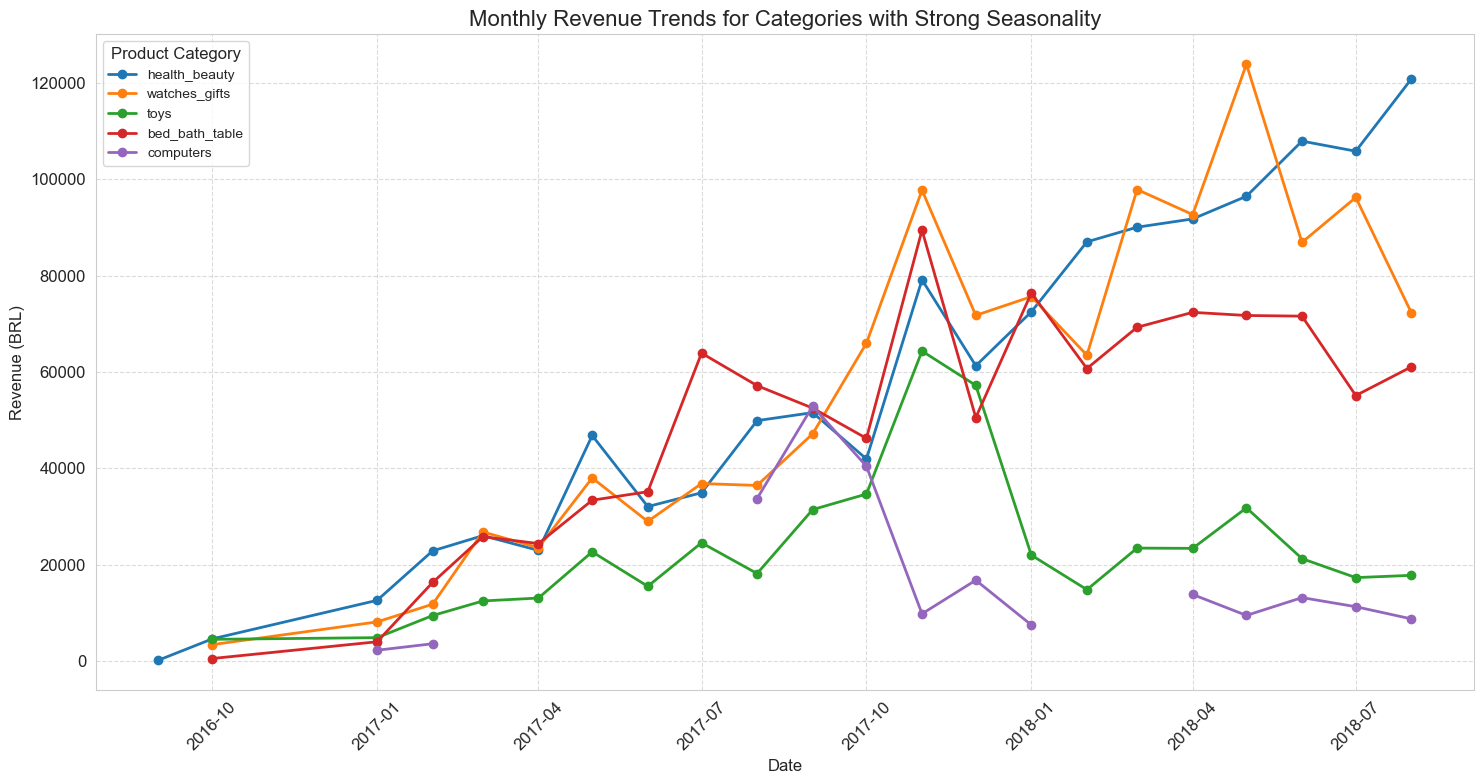

In [7]:
# Plot the seasonal patterns
plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')

for category in top_seasonal_categories:
    plt.plot(seasonal_pivot['date'], seasonal_pivot[category], label=category, linewidth=2, marker='o')

plt.title('Monthly Revenue Trends for Categories with Strong Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (BRL)', fontsize=12)
plt.legend(title='Product Category', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Impact of Delivery Performance on Customer Reviews (2016-2018)

In [8]:
# Filter for completed orders
completed_orders = orders.dropna(subset=['order_delivered_customer_date']).copy()

# Calculate delivery metrics
completed_orders['actual_delivery_days'] = (
    completed_orders['order_delivered_customer_date'] - 
    completed_orders['order_purchase_timestamp']
).dt.total_seconds() / (24 * 3600) # Convert to days

completed_orders['estimated_delivery_days'] = (
    completed_orders['order_estimated_delivery_date'] - 
    completed_orders['order_purchase_timestamp']
).dt.total_seconds() / (24 * 3600)

# Calculate delivery difference (positive = early, negative = late)
completed_orders['delivery_diff_days'] = (
    completed_orders['order_estimated_delivery_date'] - 
    completed_orders['order_delivered_customer_date']
).dt.total_seconds() / (24 * 3600)

# Create a binary flag for on-time vs late delivery
completed_orders['is_late'] = completed_orders['delivery_diff_days'] < 0


# Merge orders with review data
delivery_reviews = pd.merge(
    completed_orders[['order_id', 'delivery_diff_days', 'is_late']], 
    order_reviews[['order_id', 'review_score']], 
    on='order_id', 
    how='inner'
)

print(delivery_reviews['delivery_diff_days'].isna().sum())
# Remove NaN values before categorizing
delivery_reviews = delivery_reviews.dropna(subset=['delivery_diff_days'])

# Compare average review scores for on-time vs late deliveries
ontime_vs_late = delivery_reviews.groupby('is_late')['review_score'].agg(['mean', 'count'])

# Calculate correlation between delivery timing and review scores
correlation = delivery_reviews['delivery_diff_days'].corr(delivery_reviews['review_score'])

# Create delivery categories for more detailed analysis

bins = [-float('inf'), -10, -5, -2, 0, 3, 7, float('inf')]
labels = ['Very Late (>10 days)', 'Late (5-10 days)', 'Slightly Late (2-5 days)', 
          'On Time', 'Early (1-3 days)', 'Very Early (3-7 days)', 'Extremely Early (>7 days)']
delivery_reviews['delivery_category'] = pd.cut(delivery_reviews['delivery_diff_days'], bins=bins, labels=labels)

# Calculate average review score by delivery category

category_reviews = delivery_reviews.groupby('delivery_category', observed=False)['review_score'].agg(['mean', 'count', 'std'])




0


### Plot Results

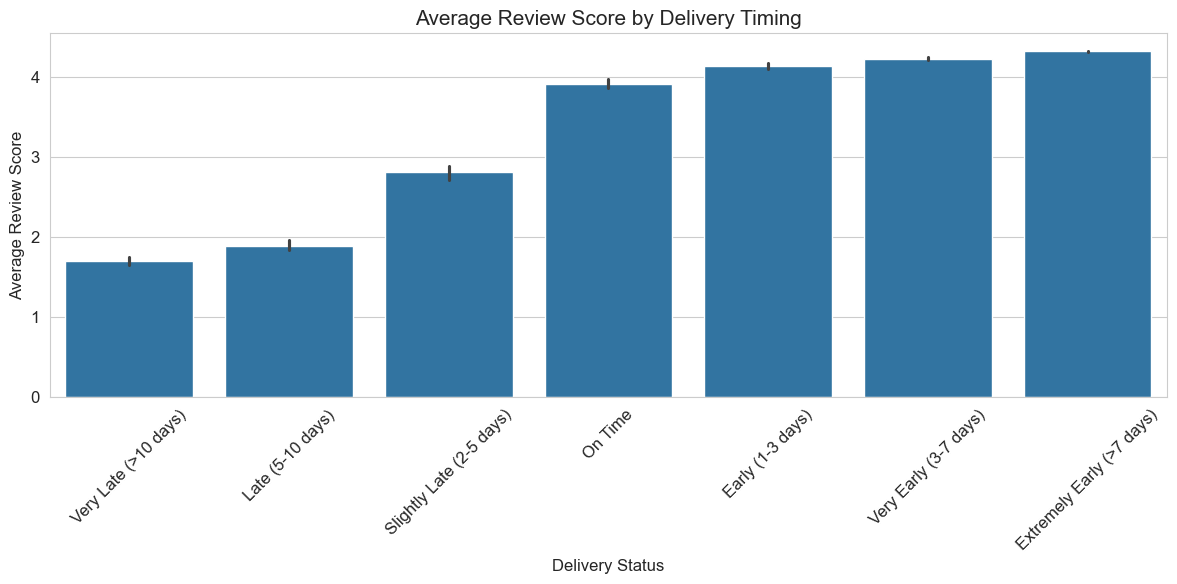

In [9]:


# Bar chart of review scores by delivery category
plt.figure(figsize=(12, 6))
sns.barplot(x='delivery_category', y='review_score', data=delivery_reviews, order=category_reviews.index)
plt.title('Average Review Score by Delivery Timing', fontsize=15)
plt.xlabel('Delivery Status', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('review_by_delivery.png')


# Identifying Growth Opportunities in Product Categories

In [10]:
# Join order_items with products and reviews
items_with_products = pd.merge(order_items, products, on='product_id', how='left')
items_with_categories = pd.merge(items_with_products, product_category, on='product_category_name', how='left')
items_with_reviews = pd.merge(items_with_categories, order_reviews[['order_id', 'review_score']], on='order_id', how='left')

# Calculate average review score by category
category_reviews = items_with_reviews.groupby('product_category_name_english')['review_score'].agg(['mean', 'count']).reset_index()

# Calculate sales volume and revenue by category
category_sales = items_with_categories.groupby('product_category_name_english').agg(
    total_sales=('price', 'sum'),
    order_count=('order_id', 'nunique'),
    item_count=('order_item_id', 'count')
).reset_index()

# Merge sales and reviews data
category_performance = pd.merge(category_sales, category_reviews, on='product_category_name_english', how='outer')

# Calculate rankings for both metrics
category_performance['sales_rank'] = category_performance['total_sales'].rank(ascending=False)
category_performance['review_rank'] = category_performance['mean'].rank(ascending=False)

# Identify categories with high satisfaction (top 25%) but low sales (bottom 50%)
opportunity_categories = category_performance[
    (category_performance['review_rank'] <= len(category_performance) * 0.25) & 
    (category_performance['sales_rank'] >= len(category_performance) * 0.5)
].sort_values('mean', ascending=False)

# Calculate opportunity score and get top 10
category_performance['satisfaction_to_sales_ratio'] = category_performance['mean'] / (category_performance['total_sales'] / 1000)
top_ratio = category_performance.sort_values('satisfaction_to_sales_ratio', ascending=False).head(10)


### Plot Results

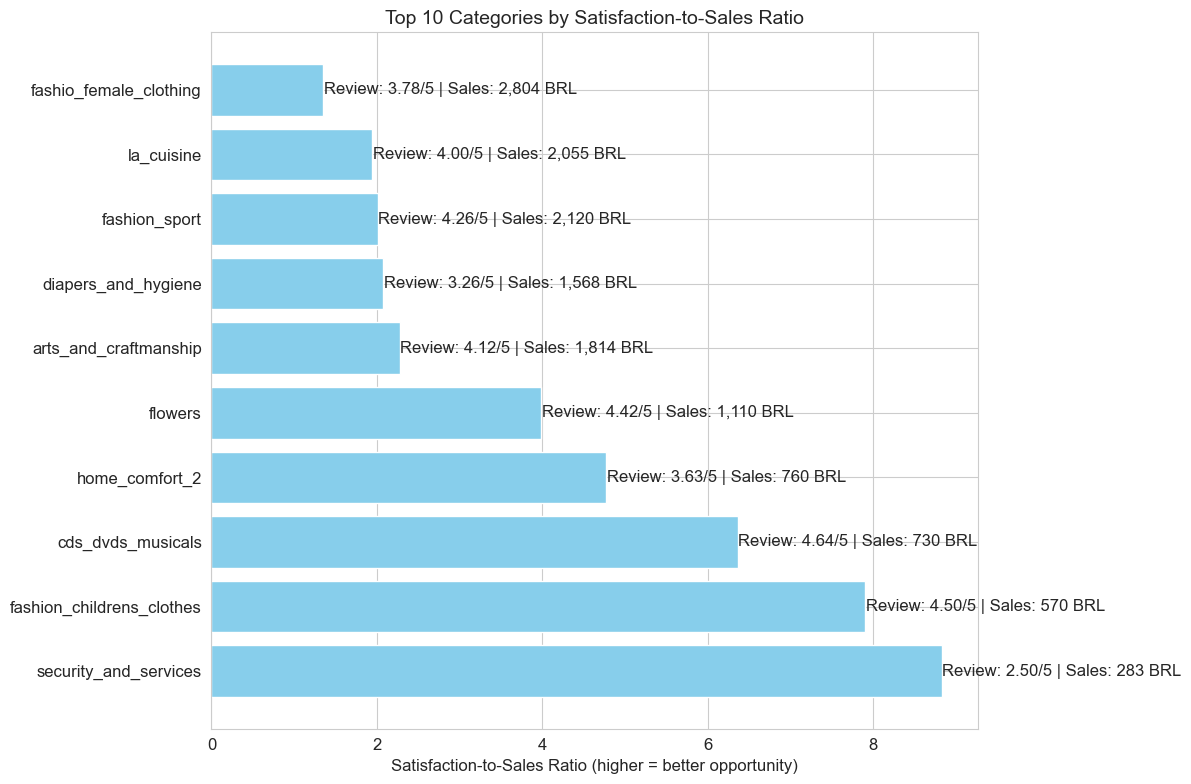

In [11]:
# Create horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(top_ratio['product_category_name_english'], top_ratio['satisfaction_to_sales_ratio'], color='skyblue')

# Add review scores and sales as text
for i, (ratio, review, sales) in enumerate(zip(top_ratio['satisfaction_to_sales_ratio'], 
                                          top_ratio['mean'], 
                                          top_ratio['total_sales'])):
    plt.text(ratio + 0.01, i, f'Review: {review:.2f}/5 | Sales: {sales:,.0f} BRL', va='center')

plt.title('Top 10 Categories by Satisfaction-to-Sales Ratio', fontsize=14)
plt.xlabel('Satisfaction-to-Sales Ratio (higher = better opportunity)', fontsize=12)
plt.tight_layout()
plt.savefig('top_opportunity_categories.png')